# Data Pre-Processing

In [2]:
#import Packages and csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("/Users/apple/Desktop/healthcare-dataset-stroke-data.csv")
# Print shape of dataset
print(df.shape)

(5110, 12)


In [3]:
# First 5 rows of the dataset
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


###Data Cleaning

In [5]:
#check null values

##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

bmi 3.93346 % missing values


In [6]:
# Checking for duplicates
df.duplicated().sum()

0

In [7]:
df.drop(['id', 'gender', 'Residence_type'], inplace=True, axis=1)

In [8]:
#Numeric Features
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(numeric_features))
numeric_features

Num of Numerical Features : 6


['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [9]:
#categorical features
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(categorical_features))
categorical_features

Num of Categorical Features : 3


['ever_married', 'work_type', 'smoking_status']

In [10]:
#Discrete features
discrete_features=[feature for feature in numeric_features if (len(df[feature].unique())<=25)]
print('Num of Discrete Features :',len(discrete_features))
discrete_features

Num of Discrete Features : 3


['hypertension', 'heart_disease', 'stroke']

In [11]:
#continuous features
continuous_features=[feature for feature in numeric_features if len(df[feature].unique()) > 25]
print('Num of Continuous Features :',len(continuous_features))
continuous_features

Num of Continuous Features : 3


['age', 'avg_glucose_level', 'bmi']

### Multicollinearity Check
#### Variance Inflation Factor (VIF)
* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [13]:
# Create copy of dataframe to check variance inflation factor
df1 = df.copy()
for i in continuous_features:
    df1[i].fillna(df1[i].median(), inplace=True)

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):

    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [15]:
compute_vif(continuous_features, df1)

,Variable,VIF
0,age,1.162810
1,avg_glucose_level,1.070325
2,bmi,1.128268


 ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable “

VIF above 5 is indicator of Multicollinearity  

**- This Dataset Doesnt have any Multicollinearity**

### Check Outlier and Capping it
**Why outliers?**
* Data Entry error : Human error.
* Measurement error: Instrument error.
* Natural error: it will be Real life data.
* Intentional error: People give wrong inputs

**Impact of Outliers ?**
* Ouliers can very high impact on few Machine learning models.
* Can Cause bias in the output.

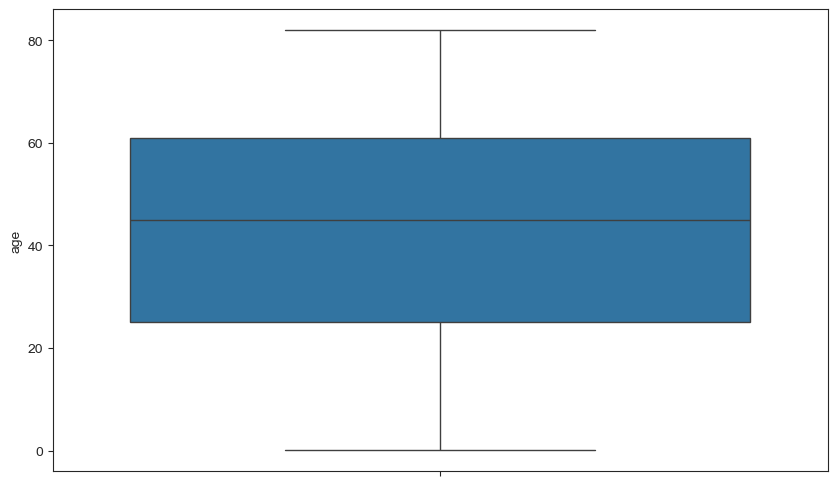

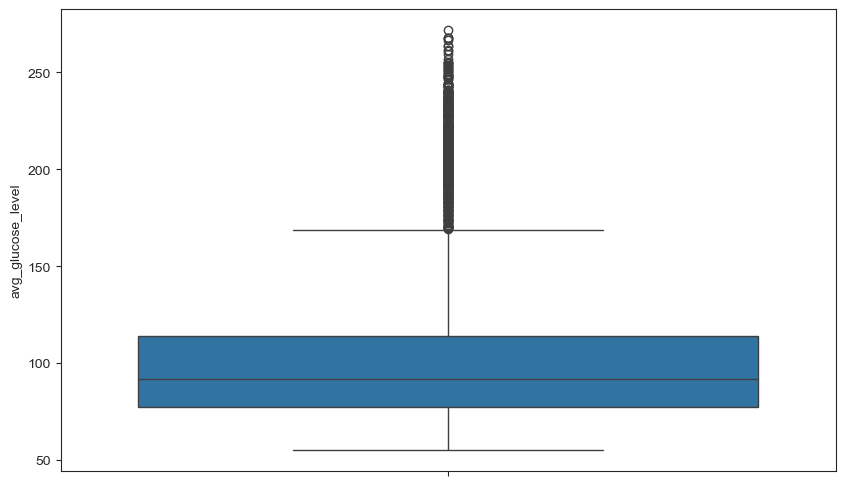

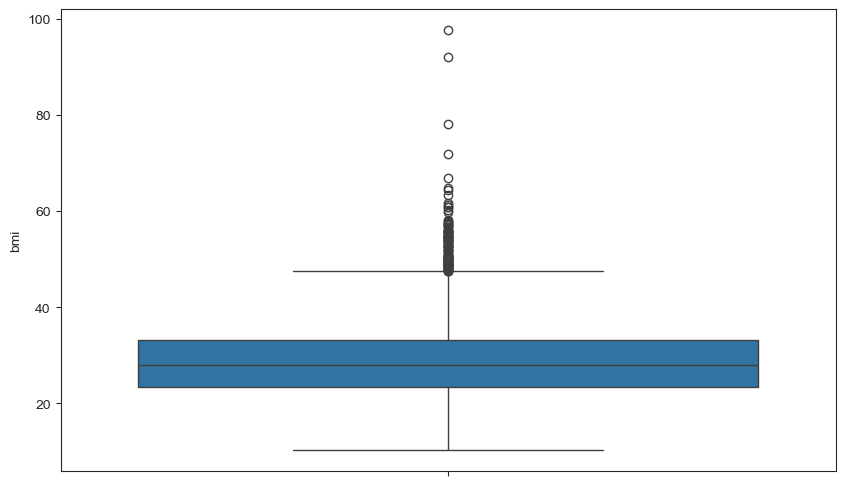

In [18]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

**Standard deviation method For Outlier Handling?**
- Outlier removal using standard deviation procedure.
- Usually z-score =3 is considered as a cut-off value to set the limit. Therefore, any z-score greater than +3 or less than -3 is considered as outlier which is pretty much similar to standard deviation method.
- Here we can remove outliers after 3rd standard deviation or z-score +3 and -3. used to remove only extreme outlier points

In [20]:
def outlier_removal(column, df):
    upper_limit = df[column].mean() + 3*df[column].std()
    lower_limit = df[column].mean() - 3*df[column].std()
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [21]:
df.shape

(5110, 9)

In [22]:
outlier_feature = ['bmi']

In [23]:
for i in range(len(outlier_feature)):
    df = outlier_removal(outlier_feature[i], df)

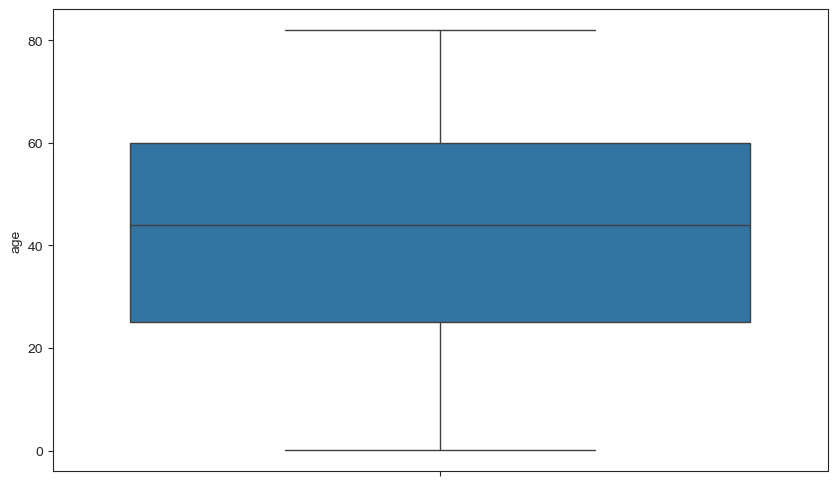

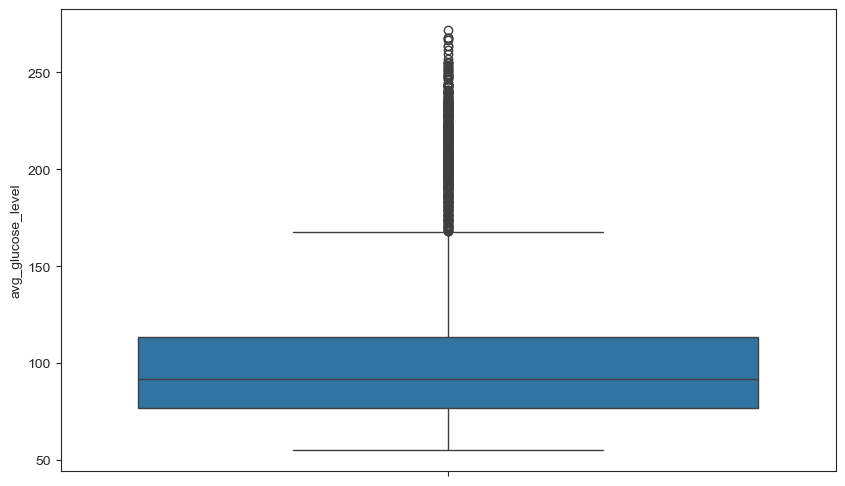

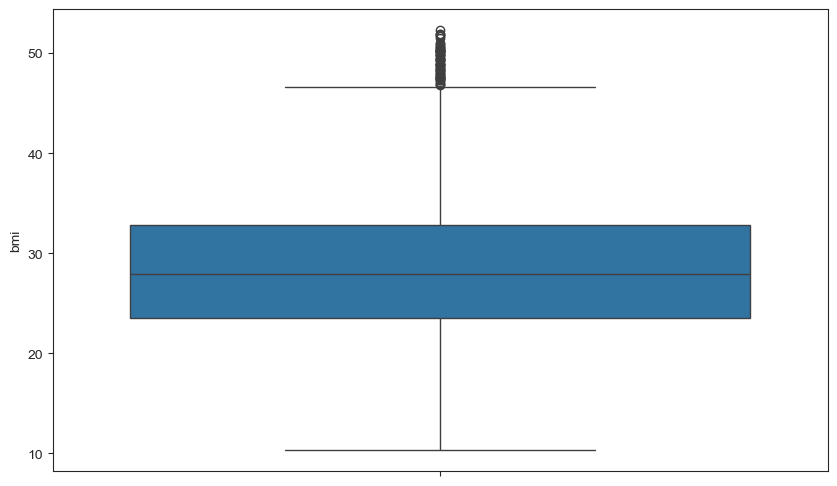

In [24]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

In [25]:
df.shape

(4851, 9)

## Feature Transformation

###skewness check
* **If Skewness is above 2 then the feature is Highly skewed**
* **If Skewness is above 1.5 then the feature is Moderately skewed**

In [28]:
df[continuous_features].skew(axis=0)


age                 -0.115593
avg_glucose_level    1.626970
bmi                  0.466922
dtype: float64

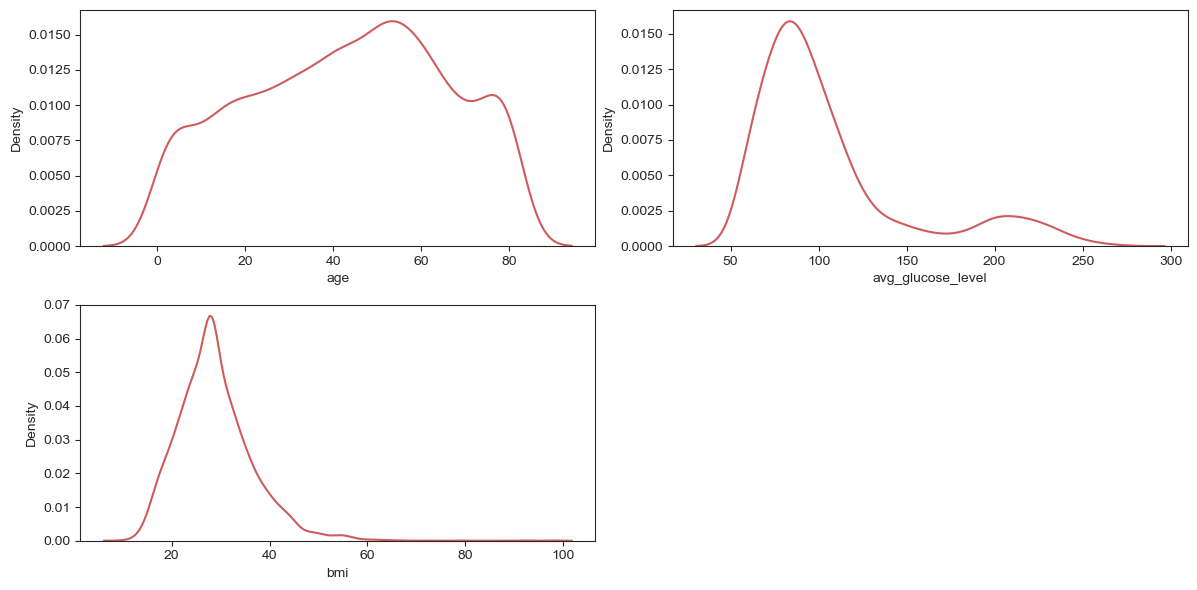

In [29]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df1[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

- **Here `avg_glucose_level` is slightly skewed**
- **`age` column have kutosis and it is platykurtic**
- **`bmi` is normally distributed with very little data on the tails**

### Split X and Y

In [32]:
from sklearn.model_selection import train_test_split
X = df.drop(['stroke'], axis=1)
y = df['stroke']

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the `stroke` column.**


In [34]:
for feature in categorical_features:
    print(feature,':', X[feature].nunique())

ever_married : 2
work_type : 5
smoking_status : 4


## Feature Encoding and Scaling
 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [36]:
for i in continuous_features:
    print(f'{i}: mean = {df[i].mean():.2f}, median = {df[i].median():.2f}')

age: mean = 42.83, median = 44.00
avg_glucose_level: mean = 105.10, median = 91.68
bmi: mean = 28.54, median = 27.90


There are no missing values in `age` and `avg_glucose_level` and only `bmi` column should be handled. Based on the above result we can inpute the column with either mean or median. We can go with median imputation since it is robust than mean imputer.
* **Mean imputer:** Since we handeled outlier for the continuous features the mean and median of the features are nearly same. When there are no outliers mean performs an a better imputer.
* **Standardscaler:** As the features distribution are nearly normal we use standard scaler.
* **Power Transformer:** Since avg_glucose_level are skewed we use Power Transformer on them

In [38]:
# Create Column Transformer with 3 types of transformers
categorical_features = X.select_dtypes(include="object").columns
num_feature = numeric_features.copy()
num_feature.remove('stroke')
transform_features=['avg_glucose_level']


from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
]
)

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(standardize=True))
])

preprocessor = ColumnTransformer(
    [
        ("numeric_Pipeline",numeric_pipeline,num_feature),
        ("Categorical_Pipeline",categorical_pipeline, categorical_features),
        ("Power_Transformation", transform_pipe, transform_features)
]
)

In [39]:
X= preprocessor.fit_transform(X)

#Handling Imbalance Dataset
* Handling Imbalanced Target Variable.
* Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model.

* SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.

 **SMOTE+ENN** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.

This method combines the SMOTE ability to generate synthetic data for minority class and uses ENN to remove overlapping observation of both the classes

 - **To add new data of minority class**
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its k nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat step number 2–3 until the desired proportion of minority class is met.

 - **To remove the data points of both classes**
 1. Determine K, as the number of nearest neighbors. If not determined, then K=3.
 2. Find the K-nearest neighbor of the observation among the other observations in the dataset, then return the majority class from the K-nearest neighbor.
 3. If the class of the observation and the majority class from the observation’s K-nearest neighbor is different, then the observation and its K-nearest neighbor are deleted from the dataset.
 4. Repeat step 2 and 3 until the desired proportion of each class is fulfilled.

 - This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [41]:
from imblearn.combine import SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

## Model Selection
* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

##Train Test Split
* The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

* It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve

In [44]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [45]:
# Initialize models which are required for models
models = {
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
     "Decision Tree": DecisionTreeClassifier(),
     "Random Forest": RandomForestClassifier(),
       
}

In [46]:
# Create a function which can evaluate models and return a report
def evaluate_models(X, y, models: dict):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    models_list = []
    accuracy_list = []
    auc= []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')

    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)

    return report

In [47]:
base_report =evaluate_models(X=X_res, y=y_res, models=models)

Logistic Regression
Model performance for Training set
- Accuracy: 0.8609
- F1 score: 0.8720
- Precision: 0.8465
- Recall: 0.8990
- Roc Auc Score: 0.8587
----------------------------------
Model performance for Test set
- Accuracy: 0.8588
- F1 score: 0.8692
- Precision: 0.8382
- Recall: 0.9026
- Roc Auc Score: 0.8570


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9873
- F1 score: 0.9881
- Precision: 0.9779
- Recall: 0.9985
- Roc Auc Score: 0.9867
----------------------------------
Model performance for Test set
- Accuracy: 0.9721
- F1 score: 0.9738
- Precision: 0.9523
- Recall: 0.9963
- Roc Auc Score: 0.9711


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9386
- F1 score: 0.9415
- Precision: 0.9330
- Recall: 0.9501
- Roc Auc Score: 0.9381


Random Forest
Model performance for Trai

In [48]:
base_report

,Model Name,Accuracy
3,Random Forest,0.979734
1,K-Neighbors Classifier,0.972134
2,Decision Tree,0.938569
0,Logistic Regression,0.858771


In [49]:
#KNN classifier and Random Forest for hyperparameter tuning

#Initialize few parameter for Hyperparamter tuning
knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}
rf_params = {
    "max_depth": [10, 12, None, 15],
    "max_features": ['sqrt', 'log2', None],
    "min_samples_split": [100, 150, 200, 300],
    "n_estimators": [10, 50, 100, 200]
}

In [50]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ("KNN", KNeighborsClassifier(), knn_params),
    ("RF", RandomForestClassifier(), rf_params)
]

In [51]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}
---------------- Best Params for RF -------------------
{'n_estimators': 50, 'min_samples_split': 100, 'max_features': 'sqrt', 'max_depth': 15}


### Retraining the Model with best Parameters

In [53]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),

}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9848
- F1 score: 0.9856
- Precision: 0.9716
- Recall: 1.0000
- Roc Auc Score: 0.9842


Random Forest Classifier
Model performance for Training set
- Accuracy: 0.9316
- F1 score: 0.9365
- Precision: 0.9160
- Recall: 0.9579
- Roc Auc Score: 0.9301
----------------------------------
Model performance for Test set
- Accuracy: 0.9158
- F1 score: 0.9215
- Precision: 0.8936
- Recall: 0.9513
- Roc Auc Score: 0.9143




In [54]:
tuned_report

,Model Name,Accuracy
0,KNeighborsClassifier,0.984801
1,Random Forest Classifier,0.915769


## Plot Roc Auc Curve

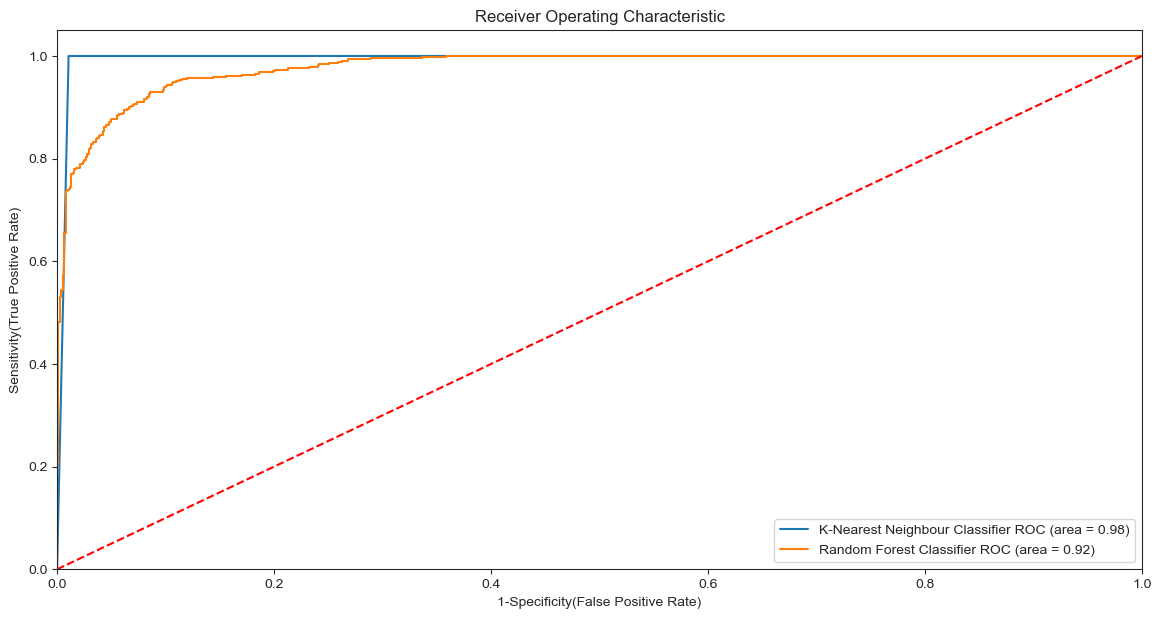

In [56]:
from sklearn.metrics import roc_auc_score,roc_curve
# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': "K-Nearest Neighbour Classifier",
    'model': KNeighborsClassifier(**model_param['KNN']),
    'auc': 0.9842
},
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(**model_param['RF']),
    'auc': 0.9152
},
]

X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
# create loop through all model
plt.figure(figsize=(14,7))
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [57]:
from sklearn.metrics import classification_report

# Assuming `y_test` and `y_pred` are the true and predicted labels
# Replace `model` with the trained model you want to evaluate
y_pred = auc_models[0]['model'].predict(X_test)  # Example using the first model

# Generate the classification report
cr = classification_report(y_test, y_pred)

# Print the classification report
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       758
           1       0.97      1.00      0.99       821

    accuracy                           0.98      1579
   macro avg       0.99      0.98      0.98      1579
weighted avg       0.99      0.98      0.98      1579



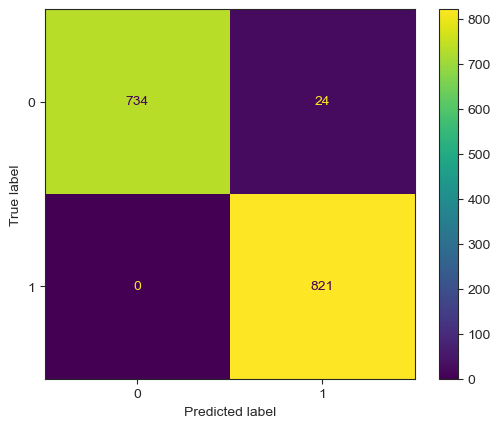

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_models["KNeighborsClassifier"], X_test, y_test)

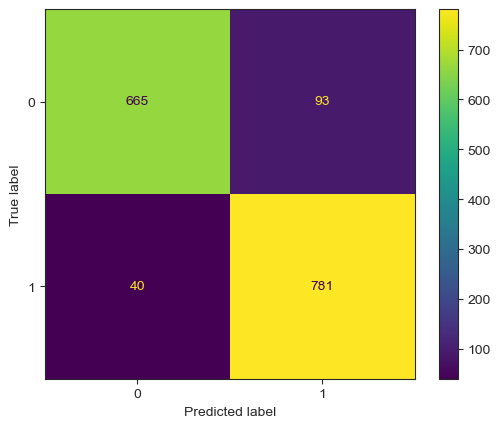

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_models["Random Forest Classifier"], X_test, y_test)

In [60]:
from sklearn.model_selection import cross_val_score

# Define the input data X and target variable y

# Loop over the models in the dictionary and perform cross-validation
for name, model in best_models.items():
    scores = cross_val_score(model, X_res, y_res, cv=5)
    print(f"{name} cross-validation scores: {scores}")
    print(f"Mean {name} cross-validation score: {scores.mean()}\n")

KNeighborsClassifier cross-validation scores: [0.98796707 0.98986058 0.98732573 0.9860583  0.98669202]
Mean KNeighborsClassifier cross-validation score: 0.987580739281652

Random Forest Classifier cross-validation scores: [0.90500317 0.91381496 0.91761724 0.90684411 0.92015209]
Mean Random Forest Classifier cross-validation score: 0.9126863113857338



## KNN  is the best model for this project

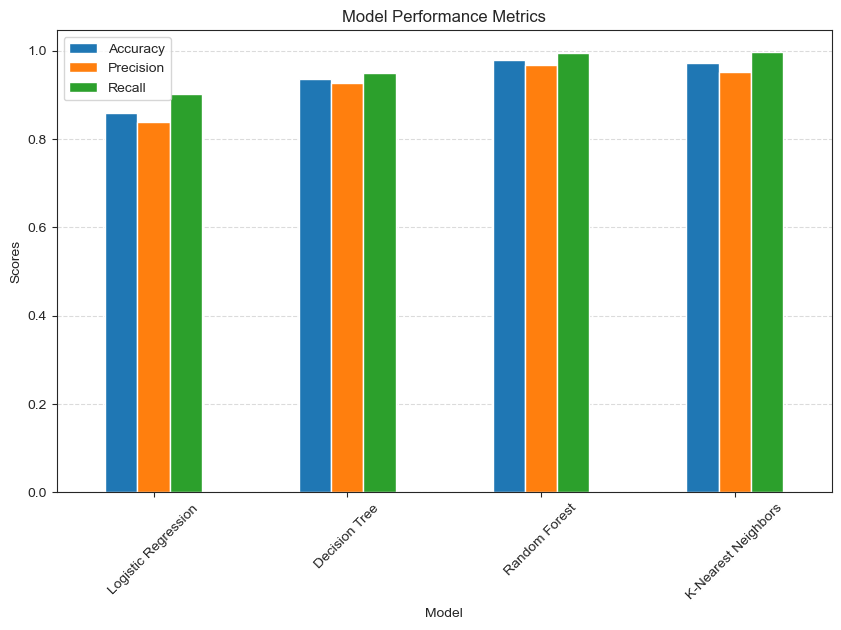

In [112]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
    
}

# Evaluate models
metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
    metrics['Recall'].append(recall_score(y_test, y_pred, zero_division=0))

# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics)

# Bar plot for accuracy, precision, and recall
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()